In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from datetime import timedelta
from netCDF4 import Dataset, date2num, num2date
import cftime
import glob
import os
import csv
%matplotlib inline
import datetime
import matplotlib.dates as mdates
import matplotlib.dates as md
import metpy.calc as mpcalc
from metpy.units import units
import matplotlib.gridspec as gridspec
from matplotlib.ticker import MaxNLocator

In [2]:
bad_files_001 = [
    '20250704_cms_amb_001.nc'
]

bad_files_002 = [
    '20250704_cms_amb_002.nc'
]

#bad_files_004 = [
#    '20250704_cms_amb_004.nc',
#    '20250709_cms_amb_004.nc',
#    '20250711_cms_amb_004.nc',
#    '20250713_cms_amb_004.nc'
    
#]



bad_files_fd70 = [
    '20250709_fd70.nc'
]

In [3]:
# Load amb001 (all dates)




files_001 = sorted(glob.glob('*_cms_amb_001.nc'))
files_001 = [f for f in files_001 if os.path.basename(f) not in bad_files_001]
amb001 = xr.open_mfdataset(files_001, combine='by_coords')


# Load amb002 (all dates)
files_002 = sorted(glob.glob('*_cms_amb_002.nc'))
files_002 = [f for f in files_002 if os.path.basename(f) not in bad_files_002]
amb002 = xr.open_mfdataset(files_002, combine='by_coords')

# Load amb004 (all dates)
files_004 = sorted(glob.glob('*_cms_amb_004.nc'))
#files_004 = [f for f in files_004 if os.path.basename(f) not in bad_files_004]
amb004 = xr.open_mfdataset(files_004, combine='by_coords')

files_fd70 = sorted(glob.glob('*_fd70.nc'))
files_fd70 = [f for f in files_fd70 if os.path.basename(f) not in bad_files_fd70]
def sort_time(ds):
    return ds.sortby('time')

fd70 = xr.open_mfdataset(
    files_fd70,
    combine='nested',
    concat_dim='time',
    preprocess=sort_time,
    parallel=True  # optional, speeds it up for many files
)

# Final sort across the whole dataset
fd70 = fd70.sortby('time')



bad_files = [
    '3dpaws_nc/recordings_2025_05_21.nc',
    '3dpaws_nc/recordings_2025_05_29.nc',
    '3dpaws_nc/recordings_2025_06_12.nc'
]

files_paws = sorted(glob.glob('3dpaws_nc/recordings_*.nc'))
files_paws = [f for f in files_paws if f not in bad_files]

def sort_time(ds):
    return ds.sortby('time')

    # --- New function to check monotonicity of time coordinate ---
def is_time_monotonic(ncfile):
    try:
        ds = xr.open_dataset(ncfile)
        time = ds['time'].values
        ds.close()
        return (time[1:] > time[:-1]).all() or (time[1:] < time[:-1]).all()
    except Exception as e:
        print(f"Error reading {ncfile}: {e}")
        return False

# Get all 3dpaws files
files_paws_all = sorted(glob.glob('3dpaws_nc/recordings_*.nc'))

# Filter files: keep only those with monotonic time
files_paws = [f for f in files_paws_all if is_time_monotonic(f)]

print(f"Using {len(files_paws)} valid 3dpaws files (excluded {len(files_paws_all)-len(files_paws)} bad files)")

# Open combined dataset for 3dpaws
paws3d = xr.open_mfdataset(files_paws, combine='by_coords', preprocess=sort_time)

timestamp = pd.to_datetime(paws3d['time'].values)

timestring = timestamp[-1].strftime("%I:%M %p")
timestring2 = timestamp[0].strftime("%Y-%m-%d")  # just ymd as you requested

first = timestamp[0]
delta = timedelta(minutes=60)
dates = list((first + delta * x for x in range(24)))
finalt = timestamp[0] + timedelta(minutes=1435)

#paws3d = xr.open_mfdataset(files_paws, combine='by_coords', preprocess=sort_time)

#timestamp = pd.to_datetime(paws3d['time'].values)

#timestring = timestamp[-1].strftime("%I:%M %p")
#timestring2 = timestamp[0].strftime("%A %m/%d/%Y")

#first = timestamp[0]
#delta = timedelta(minutes = 60)
#dates = list((first + delta * x for x in range(24)))
#finalt=timestamp[0]+timedelta(minutes=1435)




Using 34 valid 3dpaws files (excluded 1 bad files)


In [4]:
files_apg = sorted(glob.glob('*_APG.nc'))

apg = xr.open_mfdataset(files_apg, combine='by_coords')


files_tbrg = sorted(glob.glob('Downloads/processed/*_tbrg.nc'))

tbrg = xr.open_mfdataset(files_tbrg, combine='by_coords')

apg.head()








<xarray.Dataset> Size: 1kB
Dimensions:              (time: 5)
Coordinates:
  * time                 (time) datetime64[ns] 40B 2025-06-11 ... 2025-06-11T...
Data variables:
    APG_PW_Code          (time) int64 40B dask.array<chunksize=(5,), meta=np.ndarray>
    APG_Precip_Rate      (time) float64 40B dask.array<chunksize=(5,), meta=np.ndarray>
    APG_Precip_Accum     (time) float64 40B dask.array<chunksize=(5,), meta=np.ndarray>
    APG_Stat             (time) int64 40B dask.array<chunksize=(5,), meta=np.ndarray>
    APG_Car              (time) int64 40B dask.array<chunksize=(5,), meta=np.ndarray>
    APG_Raw              (time) int64 40B dask.array<chunksize=(5,), meta=np.ndarray>
    APG_Base             (time) int64 40B dask.array<chunksize=(5,), meta=np.ndarray>
    APG_Temp             (time) int64 40B dask.array<chunksize=(5,), meta=np.ndarray>
    APG_PW_Code_decoded  (time) <U37 740B dask.array<chunksize=(5,), meta=np.ndarray>

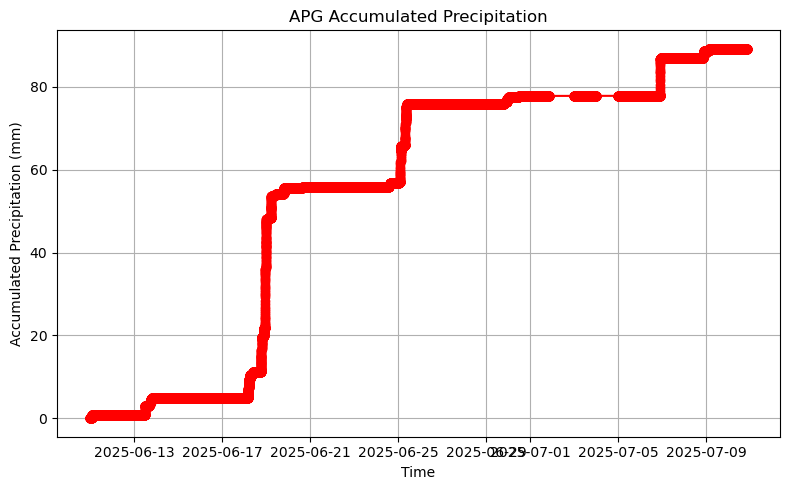

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Load precipitation rate and time values
precip_rate = apg['APG_Precip_Rate'].load().values  # in mm/hr
timeAPG = apg['time'].values  # numpy datetime64 array

# Calculate time differences in seconds
time_diff_sec = np.diff(timeAPG) / np.timedelta64(1, 's')  # array of seconds between points

# Convert rate from mm/hr to mm/s
precip_rate_s = precip_rate[:-1] / 3600  # mm/s, ignore last point for diff length match

# Calculate incremental precipitation = rate * time interval
incremental_precip = precip_rate_s * time_diff_sec  # mm

# Calculate cumulative precipitation by summing increments
accum_precip_manual = np.insert(np.cumsum(incremental_precip), 0, 0)  # start at zero

# Plot manually calculated accumulation
plt.figure(figsize=(8,5))
plt.plot(timeAPG, accum_precip_manual, marker='o', linestyle='-', color='r')
plt.title('APG Accumulated Precipitation')
plt.xlabel('Time')
plt.ylabel('Accumulated Precipitation (mm)')
plt.grid(True)
plt.tight_layout()
plt.show()


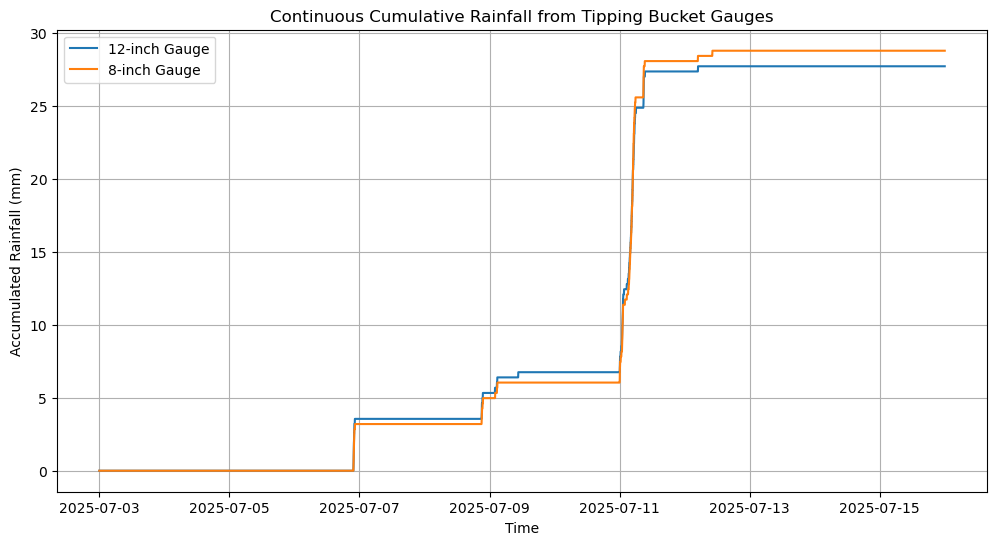

In [6]:


TIP_MM = 0.2  # Adjust if your tipping bucket size is different

# Convert tip counts to mm
accum_12in = tbrg['tb_rain_mm_12in_Tot'] * TIP_MM
accum_8in = tbrg['tb_rain_mm_8in_Tot'] * TIP_MM

# Extract tipping counts as pandas Series
tips_12in = tbrg['tb_rain_mm_12in_Tot'].to_series()
tips_8in = tbrg['tb_rain_mm_8in_Tot'].to_series()

def continuous_accumulation(tips, tip_mm):
    # Calculate increments
    increments = tips.diff()
    # Fix resets (negative increments)
    increments[increments < 0] += tips.max()
    # Fix first NaN from diff
    increments.iloc[0] = tips.iloc[0]
    # Convert to mm
    increments_mm = increments * tip_mm
    # Continuous cumulative sum
    return increments_mm.cumsum()

# Calculate continuous cumulative rainfall for both gauges
accum_12in = continuous_accumulation(tips_12in, TIP_MM)
accum_8in = continuous_accumulation(tips_8in, TIP_MM)

# Plot both
plt.figure(figsize=(12,6))
plt.plot(accum_12in.index, accum_12in.values, label='12-inch Gauge')
plt.plot(accum_8in.index, accum_8in.values, label='8-inch Gauge')
#plt.plot(
plt.xlabel('Time')
plt.ylabel('Accumulated Rainfall (mm)')
plt.title('Continuous Cumulative Rainfall from Tipping Bucket Gauges')
plt.legend()
plt.grid(True)
plt.show()



In [7]:
temperature = paws3d['mcp9808'] * units.degC
humidity = paws3d['sht_hum'] * units.percent
dewpoint = mpcalc.dewpoint_from_relative_humidity(temperature, humidity)
paws3d['dewpoint'] = dewpoint.metpy.dequantify()

# Calculate cumulative tipping bucket
#TIP_MM = 0.2
#interval_hr = 1 / 60  # assuming 1-minute interval
#paws3d['precip_rate'] = (paws3d['tipping'] * TIP_MM) / interval_hr  # mm/hr
#paws3d['cum_precip'] = paws3d['tipping'].cumsum() * TIP_MM


In [8]:
rain_series1 = amb001['dailyrainin'].squeeze().to_series()

# Initialize
corrected_cumsum1 = []
offset = 0.0
last_val = 0.0

for val in rain_series1:
    if val < last_val:  # detected a reset
        offset += last_val  # accumulate previous total
    corrected_cumsum1.append(val + offset)
    last_val = val

# Convert back to xarray DataArray
amb001['cumulative_precip_corrected'] = xr.DataArray(
    corrected_cumsum1,
    coords=[amb001['time']],
    dims=['time']
)
rain_series2 = amb002['dailyrainin'].squeeze().to_series()

# Initialize
corrected_cumsum2 = []
offset = 0.0
last_val = 0.0

for val in rain_series2:
    if val < last_val:  # detected a reset
        offset += last_val  # accumulate previous total
    corrected_cumsum2.append(val + offset)
    last_val = val

# Convert back to xarray DataArray
amb002['cumulative_precip_corrected'] = xr.DataArray(
    corrected_cumsum2,
    coords=[amb002['time']],
    dims=['time']
)
rain_series4 = amb004['dailyrainin'].squeeze().to_series()

# Initialize
corrected_cumsum4 = []
offset = 0.0
last_val = 0.0

for val in rain_series4:
    if val < last_val:  # detected a reset
        offset += last_val  # accumulate previous total
    corrected_cumsum4.append(val + offset)
    last_val = val

# Convert back to xarray DataArray
amb004['cumulative_precip_corrected'] = xr.DataArray(
    corrected_cumsum4,
    coords=[amb004['time']],
    dims=['time']
)

In [9]:
#QC the 3d paws data

def filter_precip(da):
    return da.where((da > 0) & (da < 100))
precip_clean = filter_precip(paws3d['tipping'])






In [10]:
#TIP_MM = 0.2  # Adjust if your tipping bucket size is different

# Convert tip counts to mm
accum_12in = tbrg['tb_rain_mm_12in_Tot']
accum_8in = tbrg['tb_rain_mm_8in_Tot']

# Extract tipping counts as pandas Series
#tips_12in = tbrg['tb_rain_mm_12in_Tot'].to_series()
#tips_8in = tbrg['tb_rain_mm_8in_Tot'].to_series()

#def continuous_accumulation(tips, tip_mm):
    # Calculate increments
 #   increments = tips.diff()
    # Fix resets (negative increments)
 #   increments[increments < 0] += tips.max()
    # Fix first NaN from diff
 #   increments.iloc[0] = tips.iloc[0]
    # Convert to mm
 #   increments_mm = increments * tip_mm
    # Continuous cumulative sum
 #   return increments_mm.cumsum()

# Calculate continuous cumulative rainfall for both gauges
#accum_12in = continuous_accumulation(tips_12in, TIP_MM)
#accum_8in = continuous_accumulation(tips_8in, TIP_MM)

# Plot both
#plt.figure(figsize=(12,6))
#plt.plot(accum_12in.index, accum_12in.values, label='12-inch Gauge')
#plt.plot(accum_8in.index, accum_8in.values, label='8-inch Gauge')
#plt.plot(paws_precip.index, paws_rolling_precip, '--', color = 'deeppink', label = '3D-PAWS')
#plt.plot(amb001['time'], accumPrecip001_in_mm, '--', color = 'blue', label = 'amb001')
#plt.plot(amb002['time'], accumPrecip002_in_mm, '--', color = 'green', label = 'amb002')
#plt.plot(amb004['time'], accumPrecip004_in_mm, '--', color = 'orange', label = 'amb004')
#plt.xlabel('Time')
#plt.ylabel('Accumulated Rainfall (mm)')
#plt.title('Continuous Cumulative Rainfall from Tipping Bucket Gauges')
#plt.legend()
#plt.grid(True)
#plt.show()



In [11]:
# Convert to Fahrenheit
tempF_fd70 = (fd70['temperature'] * 9/5) + 32
tempF_paws = (paws3d['mcp9808'] * 9/5) + 32
dewF_paws = (paws3d['dewpoint'] * 9/5) + 32

# Precip rate and accumulation for 3d paws
paws3d['cum'] = precip_clean.cumsum()


def filter_temperature(da):
    return da.where((da > -40) & (da < 130))

tempF_paws_clean = filter_temperature(tempF_paws)

def filter_humidity(db):
    return db.where((db > 0) & (db < 100))
paws_humidity_clean = filter_humidity(paws3d['sht_hum'])

hum_max = fd70['relative_humidity'].max()+5


    
fd70['cum'] = (fd70['precip_intensity'] / 3600).cumsum()
fd70_cum_max = fd70['cum'].max()




amb001_to_ms = amb001['windspeedmph']/2.237
amb002_to_ms = amb002['windspeedmph']/2.237
amb004_to_ms = amb004['windspeedmph']/2.237

amb001gust_to_ms = amb001['windgustmph']/2.237
amb002gust_to_ms = amb002['windgustmph']/2.237
amb004gust_to_ms = amb004['windgustmph']/2.237



# --- Calculate 10-minute rolling averages for wind speed ---
# Convert to pandas Series with datetime index
paws_wind = pd.Series(paws3d['wind_speed'].values, index=pd.to_datetime(paws3d['time'].values))
amb001_wind = pd.Series(amb001_to_ms[0, :].values, index=pd.to_datetime(amb001['time'].values))
amb002_wind = pd.Series(amb002_to_ms[0, :].values, index=pd.to_datetime(amb002['time'].values))
amb004_wind = pd.Series(amb004_to_ms[0, :].values, index=pd.to_datetime(amb004['time'].values))

# Apply rolling mean
paws_rolling = paws_wind.rolling(window=10, min_periods=1).mean()       # 10 minutes @ 1-minute interval
amb001_rolling = amb001_wind.rolling(window=2, min_periods=1).mean()    # 10 minutes @ 5-minute interval
amb002_rolling = amb002_wind.rolling(window=2, min_periods=1).mean()
amb004_rolling = amb004_wind.rolling(window=2, min_periods=1).mean()

# for wind gusts now

amb001_wind_gust = pd.Series(amb001gust_to_ms[0, :].values, index=pd.to_datetime(amb001['time'].values))
amb002_wind_gust = pd.Series(amb002gust_to_ms[0, :].values, index=pd.to_datetime(amb002['time'].values))
amb004_wind_gust = pd.Series(amb004gust_to_ms[0,:].values, index=pd.to_datetime(amb004['time'].values))

# Apply rolling mean
       # 10 minutes @ 1-minute interval
amb001_rolling_gust = amb001_wind_gust.rolling(window=2, min_periods=1).mean()    # 10 minutes @ 5-minute interval
amb002_rolling_gust = amb002_wind_gust.rolling(window=2, min_periods=1).mean()
amb004_rolling_gust = amb004_wind_gust.rolling(window=2, min_periods=1).mean()

#5 min avg for precip for 3d paws
paws_precip = pd.Series(paws3d['cum'].values, index=pd.to_datetime(paws3d['time'].values))
paws_rolling_precip = paws_precip.rolling(window=5, min_periods=1).mean() 


In [12]:
note = "**3D-PAWS was not sited until 06/11/2025**"
note2 = '**Ambient stations were down between 07/03 - 07/05**'

In [13]:
fd70_humidity_mean = fd70['relative_humidity'].resample(time = '1min').mean()
fd70_time_mean = fd70['time'].resample(time = '1min').mean()

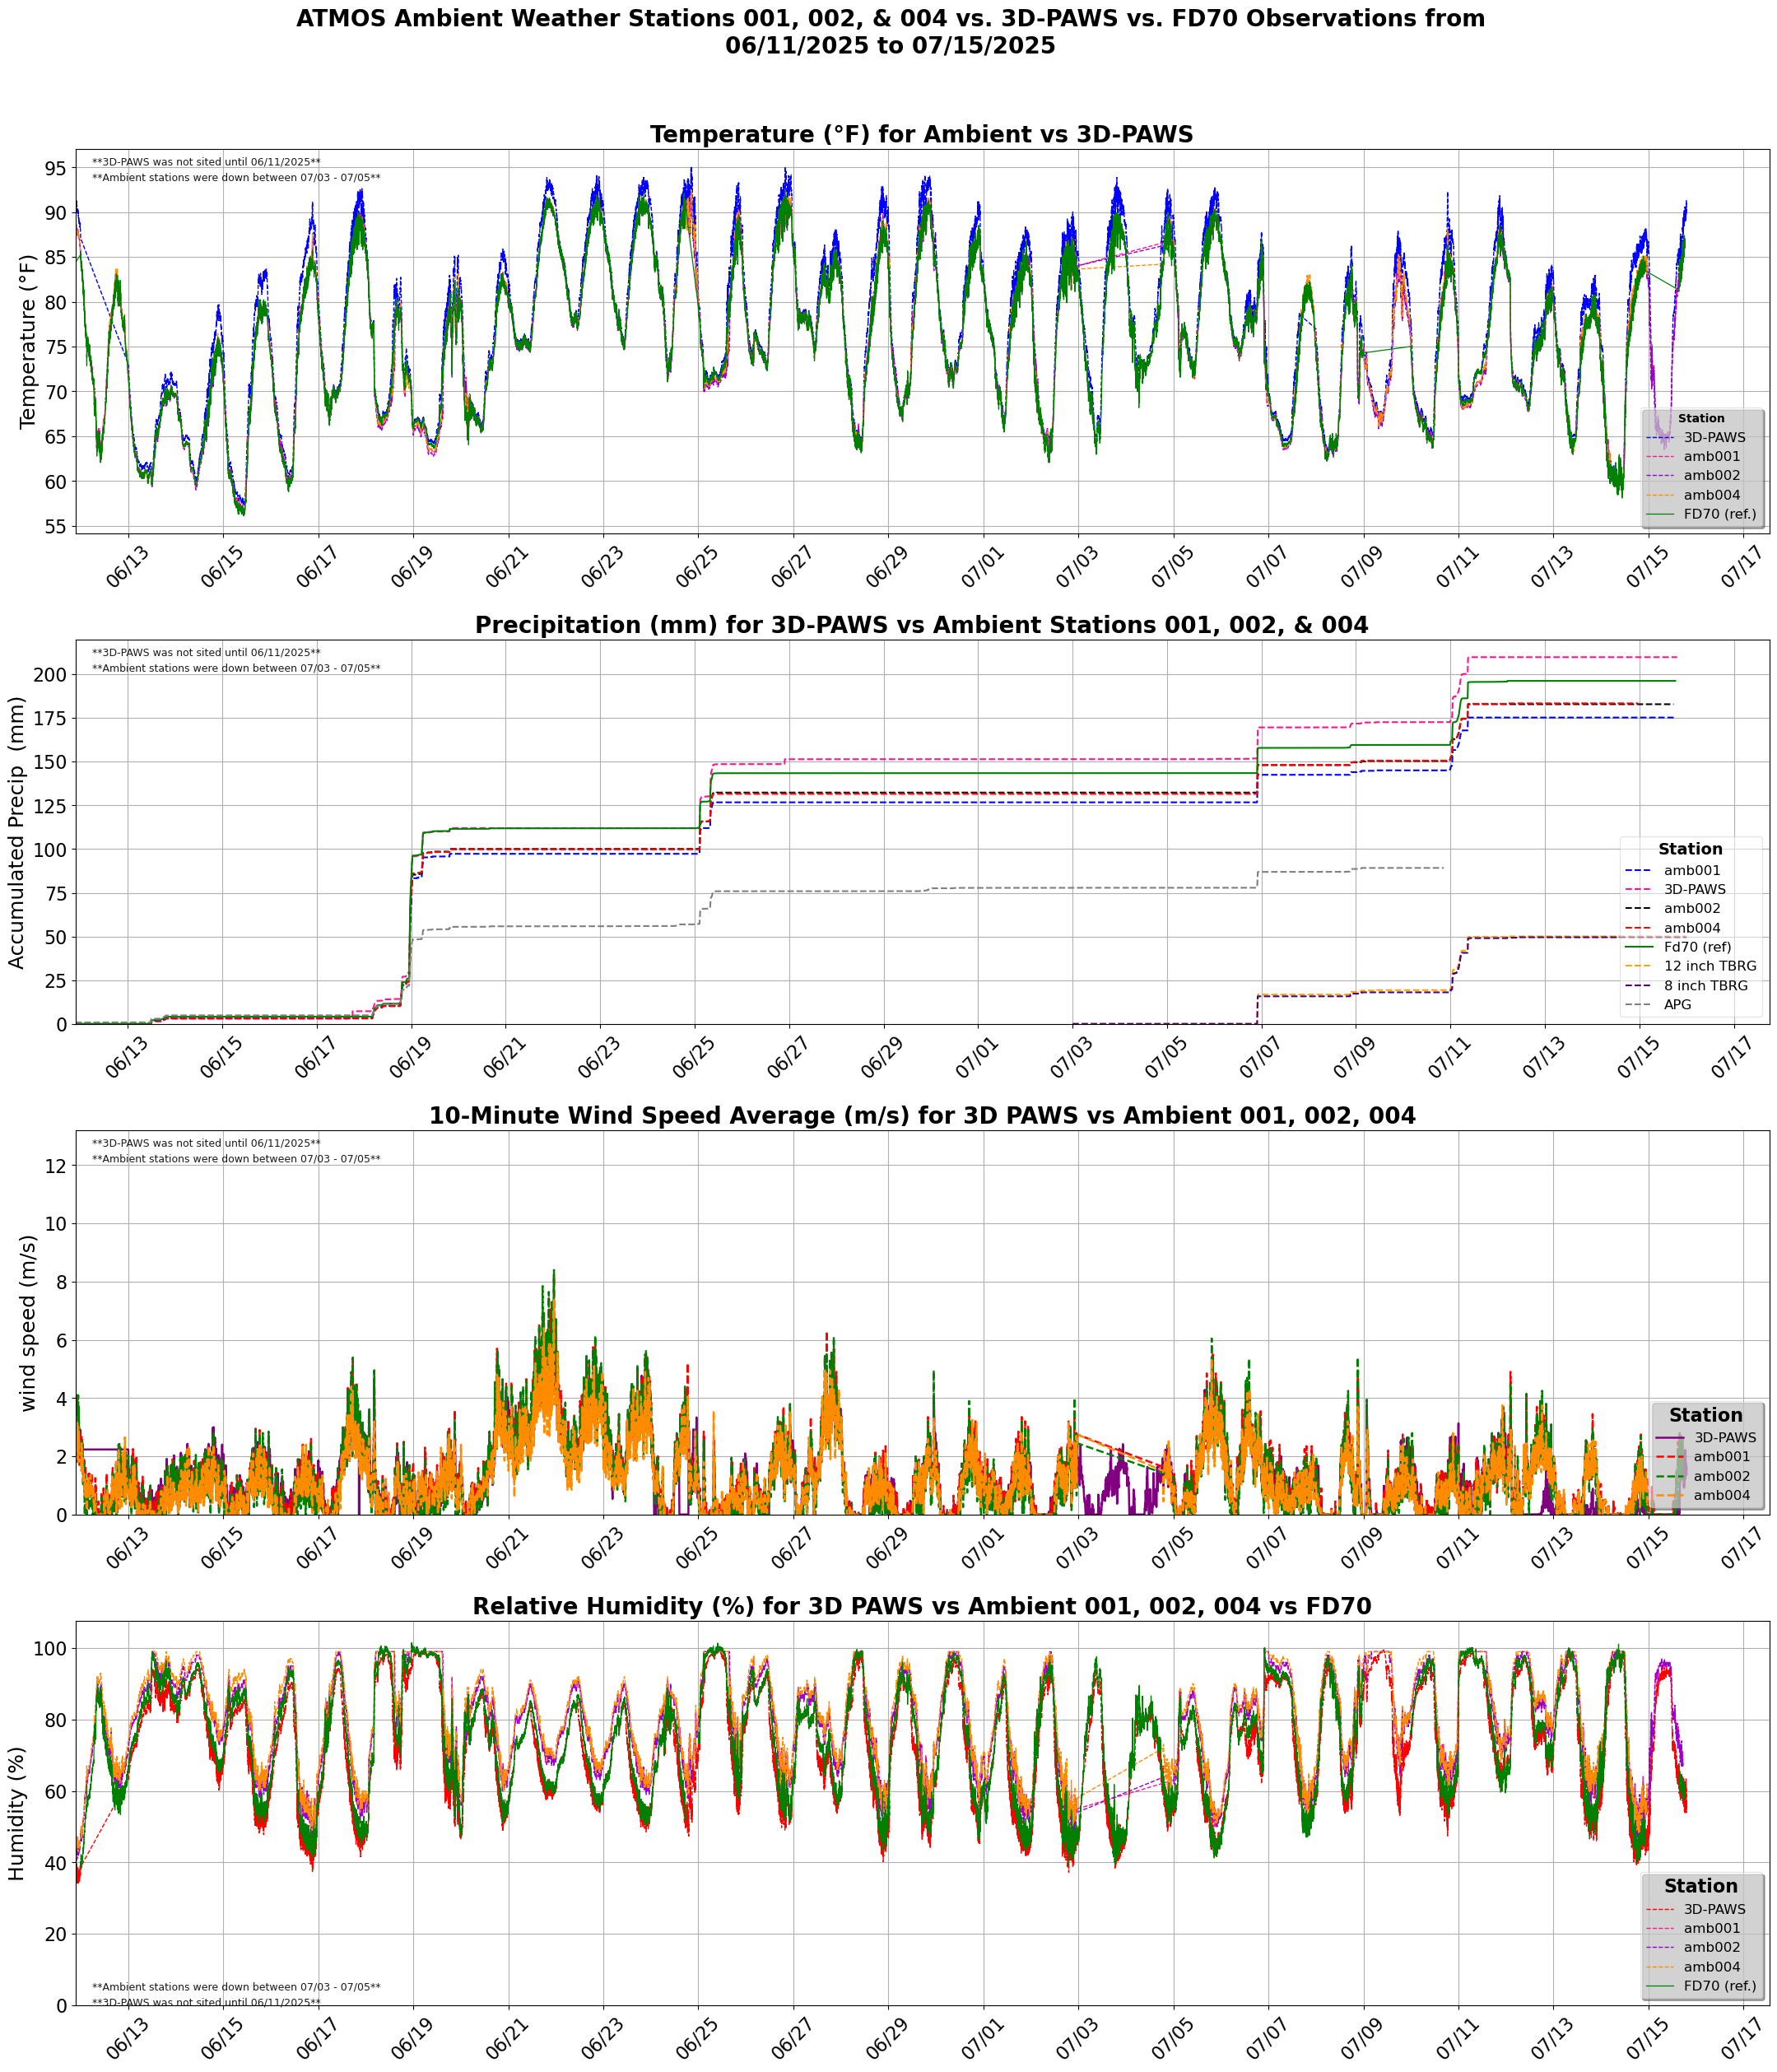

In [34]:
fig = plt.figure(figsize = (22, 25))
spec2 = gridspec.GridSpec(ncols = 1, nrows = 4, figure = fig)
ax1 = fig.add_subplot(spec2[0, 0])
ax2 = fig.add_subplot(spec2[1, 0])
ax3 = fig.add_subplot(spec2[2,0])
ax4 = fig.add_subplot(spec2[3,0])
#ax5 = fig.add_subplot(spec2[4,0])




ax1.plot(paws3d['time'], tempF_paws_clean, '--', color = 'blue', linewidth = 1, label = '3D-PAWS' )
ax1.plot(amb001['time'], amb001['outdoor_temperature'][0,:], '--', color = 'deeppink', linewidth = 1, label = 'amb001')
ax1.plot(amb002['time'],amb002['outdoor_temperature'][0,:], '--', color = 'darkviolet', linewidth = 1, label = 'amb002')
ax1.plot(amb004['time'], amb004['outdoor_temperature'][0,:], '--', color = 'darkorange', linewidth = 1, label = 'amb004')
ax1.plot(fd70['time'], tempF_fd70, '-', color = 'green', linewidth = .9, label = 'FD70 (ref.)' )




#ax1.plot(paws3d['time'], tempMCP_dew, '-', color = 'green', linewidth = 1.1, label = '3D-PAWS (dp.)' )
#ax1.plot(amb001['time'], amb001['dewpoint1'][0,:], ':', color = 'blue', linewidth = 1, label = 'Dew point (°F) from amb001')
ax1.set_ylabel("Temperature (°F)", fontsize = 18)
ax1.set_title("Temperature (°F) for Ambient vs 3D-PAWS", fontsize = 20, fontweight = 'bold')
#ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M')) 
ax1.xaxis.set_major_locator(mdates.DayLocator(interval=2))  # every 2 days
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))

ax1.tick_params(axis='x', rotation=45)
ax1.grid(True)
ax1.tick_params(axis = 'x', which = 'major', labelsize = 16)
ax1.tick_params(axis = 'y', which = 'major', labelsize = 16)
legend1 = ax1.legend(loc='lower right', framealpha=.5, shadow=True, fontsize=12, title='Station', title_fontsize=10)
legend1.get_title().set_fontweight('bold')






#precip plot

# Convert to mm
accumPrecip001_in_mm = amb001['cumulative_precip_corrected'] * 25.4
accumPrecip002_in_mm = amb002['cumulative_precip_corrected'] * 25.4
accumPrecip004_in_mm = amb004['cumulative_precip_corrected'] * 25.4
#set all ambient data to mm
precipRate001_in_mm = (amb001['hourlyrainin'].squeeze())*25.4
precipRate002_in_mm = (amb002['hourlyrainin'].squeeze())*25.4
precipRate004_in_mm = (amb004['hourlyrainin'].squeeze())*25.4

#precipRate002_in_mm = (amb002['hourlyrainin'].squeeze())*25.4
#accumPrecip002_in_mm = ((amb002['dailyrainin'].squeeze())*25.4)

#precipRate004_in_mm = (amb004['hourlyrainin'].squeeze())*25.4
#accumPrecip004_in_mm = ((amb004['dailyrainin'].squeeze())*25.4)









#line1, = ax2.plot(amb001['time'], precipRate001_in_mm , color='blue', label='Precip rate for amb001 (mm/hr)')
#ax2a = ax2.twinx()
line2, = ax2.plot(amb001['time'], accumPrecip001_in_mm, '--', color = 'blue', label = 'amb001')

#line3, = ax2.plot(paws3d['time'], paws3d['precip_rate'], color = 'green', label = 'Precip rate for 3D-PAWS (mm/hr)')
line4, = ax2.plot(paws_precip.index, paws_rolling_precip, '--', color = 'deeppink', label = '3D-PAWS')

#line5, = ax2.plot(amb002['time'], precipRate002_in_mm , color='black', label='Precip rate for amb002 (mm/hr)')
line6, = ax2.plot(amb002['time'], accumPrecip002_in_mm, '--', color = 'black', label = 'amb002')

#line7, = ax2.plot(amb004['time'], precipRate004_in_mm , color='red', label='Precip rate for amb004 (mm/hr)')
line8, = ax2.plot(amb004['time'], accumPrecip004_in_mm, '--', color = 'red', label = 'amb004')

#line9, = ax2.plot(fd70['time'], fd70['precip_intensity'] , color='purple', label='Precip rate for Fd70 (ref) (mm/hr)')
line10, = ax2.plot(fd70['time'], fd70['cum'], '-', color = 'green', label = 'Fd70 (ref)')

line12, = ax2.plot(tbrg['time'], accum_12in.values, '--', color = 'orange', label = '12 inch TBRG')

line14, = ax2.plot(tbrg['time'], accum_8in.values, '--', color = 'indigo', label = '8 inch TBRG')

line16, = ax2.plot(timeAPG, accum_precip_manual, '--', color = 'gray', label = 'APG')

ax2.set_ylabel("Accumulated Precip  (mm)", fontsize = 18 )
ax2.set_title("Precipitation (mm) for 3D-PAWS vs Ambient Stations 001, 002, & 004", fontsize = 20, fontweight = 'bold')
ax2.xaxis.set_major_locator(mdates.DayLocator(interval=2))  # repeat for ax2
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))

#ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M')) 
ax2.tick_params(axis='x', rotation=45)
ax2.grid(True)
ax2.set_ylim(bottom = 0)
ax2.set_ylim(0, paws3d['cum'].max()+10)
#ax2.set_ylim(top = precip2_max + 15)
#ax2a.set_ylim(bottom = 0)
#ax2a.set_ylim(top = cum2_max + 10)
#ax2a.set_ylabel('cumulative precip (mm)')
ax2.tick_params(axis = 'x', which = 'major', labelsize = 16)
ax2.tick_params(axis = 'y', which = 'major', labelsize = 16)
#ax2.legend(loc='upper left', framealpha=1, shadow=True, fontsize=12, title='Accumulation type', title_fontsize=10)

lines = [ line2,  line4,  line6,  line8,  line10, line12, line14, line16]
labels = [line.get_label() for line in lines]
legend2 = ax2.legend(lines, labels, loc='lower right', framealpha=.5, shadow=False,
           fontsize=12, title='Station', title_fontsize=14)
legend2.get_title().set_fontweight('bold')

#ax3.plot(paws3d['time'], paws3d['wind_speed'], label = '3D-PAWS', color='purple')
#ax3.plot(amb001['time'], amb001_to_ms[0,:], '--', label = 'amb001', color='red')
#ax3.plot(amb002['time'], amb002_to_ms[0,:], '--', label = 'amb002', color='green')
#ax3.plot(amb004['time'], amb004_to_ms[0,:],'--', label = 'amb004', color='orange')

ax3.plot(paws_rolling.index, paws_rolling, label='3D-PAWS', linewidth = 1.8, color='purple')
ax3.plot(amb001_rolling.index, amb001_rolling, '--', label='amb001', linewidth = 1.8, color='red')
ax3.plot(amb002_rolling.index, amb002_rolling, '--', label='amb002', linewidth = 1.8, color='green')
ax3.plot(amb004_rolling.index, amb004_rolling, '--', label='amb004', linewidth = 1.8, color='darkorange')
ax3.set_ylabel("wind speed (m/s)", fontsize = 18)
ax3.set_title("10-Minute Wind Speed Average (m/s) for 3D PAWS vs Ambient 001, 002, 004", fontweight = 'bold', fontsize = 20)
ax3.xaxis.set_major_locator(mdates.DayLocator(interval=2))  # repeat for ax3
ax3.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
legend3 = ax3.legend(loc='lower right', framealpha=.5, shadow=True, fontsize=12, title='Station', title_fontsize=16)
legend3.get_title().set_fontweight('bold')

#ax3.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M')) 
ax3.set_ylim(ymin = 0)
ax3.set_ylim(ymax = amb001_rolling.max()+5)
ax3.tick_params(axis='x', rotation=45)
ax3.grid(True)
ax3.tick_params(axis = 'x', which = 'major', labelsize = 16)
ax3.tick_params(axis = 'y', which = 'major', labelsize = 16)


ax4.plot(paws3d['time'], paws_humidity_clean, '--', color = 'red', linewidth = 1, label = '3D-PAWS' )
ax4.plot(amb001['time'], amb001['humidity'][0,:], '--', color = 'deeppink', linewidth = 1, label = 'amb001')
ax4.plot(amb002['time'],amb002['humidity'][0,:], '--', color = 'darkviolet', linewidth = 1, label = 'amb002')
ax4.plot(amb004['time'], amb004['humidity'][0,:], '--', color = 'darkorange', linewidth = 1, label = 'amb004')
ax4.plot(fd70_time_mean, fd70_humidity_mean, '-', color = 'green', linewidth = .9, label = 'FD70 (ref.)' )
ax4.set_ylabel("Humidity (%)", fontsize = 18)
ax4.set_title("Relative Humidity (%) for 3D PAWS vs Ambient 001, 002, 004 vs FD70", fontweight = 'bold', fontsize=20)
ax4.xaxis.set_major_locator(mdates.DayLocator(interval=2))  # repeat for ax4
ax4.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
ax4.tick_params(axis='x', rotation=45)
ax4.tick_params(axis = 'x', which = 'major', labelsize = 16)
ax4.tick_params(axis = 'y', which = 'major', labelsize = 16)
ax4.grid(True)
ax4.set_ylim(ymin = 0, ymax = hum_max)
legend4 = ax4.legend(loc='lower right', framealpha=.5, shadow=True, fontsize=12, title='Station', title_fontsize=16)
legend4.get_title().set_fontweight('bold')


#ax5.plot(amb001_wind_gust.index, amb001_rolling_gust, '--', color = 'deeppink', linewidth = 1, label = 'amb001')
#ax5.plot(amb002_wind_gust.index,amb002_rolling_gust, '--', color = 'darkviolet', linewidth = 1, label = 'amb002')
#ax5.plot(amb004_wind_gust.index, amb004_rolling_gust, '--', color = 'darkorange', linewidth = 1, label = 'amb004')
#ax5.set_ylabel("Wind Gusts (m/s)")
#ax5.set_title("Wind Gusts (m/s) for Ambient")
#ax5.xaxis.set_major_locator(mdates.DayLocator(interval=2))  # repeat for ax4
#ax5.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
#ax5.tick_params(axis='x', rotation=45)
#ax5.grid(True)
#legend5 = ax5.legend(loc='lower right', framealpha=.5, shadow=True, fontsize=9, title='Station', title_fontsize=10)
#legend5.get_title().set_fontweight('bold')



ax1.set_xlim(xmin=timestamp[0])
ax2.set_xlim(xmin=timestamp[0])
ax3.set_xlim(xmin=timestamp[0])
ax4.set_xlim(xmin=timestamp[0])
#ax5.set_xlim(xmin=timestamp[0])


# Add to ax1 (temperature)
ax1.text(0.01, 0.98, note, transform=ax1.transAxes, fontsize=9, color='black',
         verticalalignment='top', horizontalalignment='left', alpha=0.9)

# Add to ax2 (precip)
ax2.text(0.01, 0.98, note, transform=ax2.transAxes, fontsize=9, color='black',
         verticalalignment='top', horizontalalignment='left', alpha=0.9)

# Add to ax3 (wind)
ax3.text(0.01, 0.98, note, transform=ax3.transAxes, fontsize=9, color='black',
         verticalalignment='top', horizontalalignment='left', alpha=0.9)

# Add to ax4 (humidity or other)
ax4.text(0.01, 0.02, note, transform=ax4.transAxes, fontsize=9, color='black',
         verticalalignment='top', horizontalalignment='left', alpha=0.9)


##note2
ax1.text(0.01, 0.94, note2, transform=ax1.transAxes, fontsize=9, color='black',
         verticalalignment='top', horizontalalignment='left', alpha=0.9)
ax2.text(0.01, 0.94, note2, transform=ax2.transAxes, fontsize=9, color='black',
         verticalalignment='top', horizontalalignment='left', alpha=0.9)
ax3.text(0.01, 0.94, note2, transform=ax3.transAxes, fontsize=9, color='black',
         verticalalignment='top', horizontalalignment='left', alpha=0.9)
ax4.text(0.01, 0.06, note2, transform=ax4.transAxes, fontsize=9, color='black',
         verticalalignment='top', horizontalalignment='left', alpha=0.9)
#ax5.text(0.01, 0.94, note2, transform=ax5.transAxes, fontsize=9, color='black',
         #verticalalignment='top', horizontalalignment='left', alpha=0.9)


plt.setp(ax1.get_xticklabels(), fontsize=16)
plt.setp(ax2.get_xticklabels(), fontsize=16)
plt.setp(ax3.get_xticklabels(), fontsize=16)
plt.setp(ax4.get_xticklabels(), fontsize=16)
#plt.setp(ax5.get_xticklabels(), fontsize=16)

plt.setp(ax1.get_yticklabels(), fontsize=16)
plt.setp(ax2.get_yticklabels(), fontsize=16)
plt.setp(ax3.get_yticklabels(), fontsize=16)
plt.setp(ax4.get_yticklabels(), fontsize=16)
#plt.setp(ax5.get_yticklabels(), fontsize=16)

#fig.suptitle('ATMOS Ambient Weather Stations 001, 002, & 004 vs. 3D-PAWS Observations, '+timestring2, fontsize = 20, y=.8, fontweight='bold')
start_str = timestamp[0].strftime("%m/%d/%Y")
end_str = timestamp[-1].strftime("%m/%d/%Y")

fig.suptitle(f'ATMOS Ambient Weather Stations 001, 002, & 004 vs. 3D-PAWS vs. FD70 Observations from\n{start_str} to {end_str}', fontsize=20, y=1.01, fontweight='bold')

plt.tight_layout(pad = 2.0)
plt.savefig('good data over time.png', dpi=2000)
plt.show()

In [15]:
print("All files found for amb004:")
for f in files_004:
    print(f)

All files found for amb004:
20250611_cms_amb_004.nc
20250612_cms_amb_004.nc
20250613_cms_amb_004.nc
20250614_cms_amb_004.nc
20250615_cms_amb_004.nc
20250616_cms_amb_004.nc
20250617_cms_amb_004.nc
20250618_cms_amb_004.nc
20250619_cms_amb_004.nc
20250620_cms_amb_004.nc
20250621_cms_amb_004.nc
20250622_cms_amb_004.nc
20250623_cms_amb_004.nc
20250624_cms_amb_004.nc
20250625_cms_amb_004.nc
20250626_cms_amb_004.nc
20250627_cms_amb_004.nc
20250628_cms_amb_004.nc
20250629_cms_amb_004.nc
20250630_cms_amb_004.nc
20250701_cms_amb_004.nc
20250702_cms_amb_004.nc
20250704_cms_amb_004.nc
20250705_cms_amb_004.nc
20250706_cms_amb_004.nc
20250707_cms_amb_004.nc
20250708_cms_amb_004.nc
20250709_cms_amb_004.nc
20250710_cms_amb_004.nc
20250711_cms_amb_004.nc
20250712_cms_amb_004.nc
20250713_cms_amb_004.nc
20250714_cms_amb_004.nc


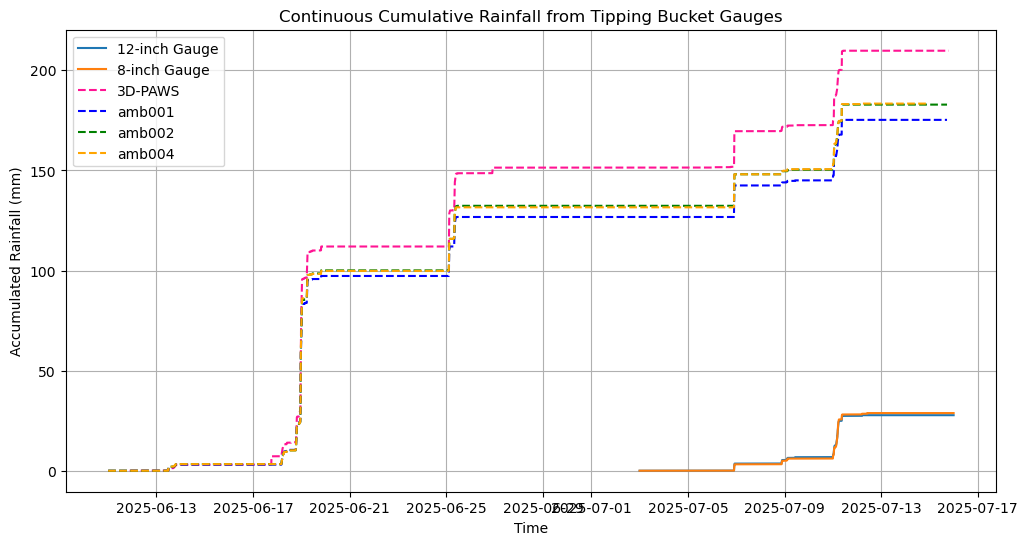

In [16]:
TIP_MM = 0.2  # Adjust if your tipping bucket size is different

# Convert tip counts to mm
accum_12in = tbrg['tb_rain_mm_12in_Tot'] * TIP_MM
accum_8in = tbrg['tb_rain_mm_8in_Tot'] * TIP_MM

# Extract tipping counts as pandas Series
tips_12in = tbrg['tb_rain_mm_12in_Tot'].to_series()
tips_8in = tbrg['tb_rain_mm_8in_Tot'].to_series()

def continuous_accumulation(tips, tip_mm):
    # Calculate increments
    increments = tips.diff()
    # Fix resets (negative increments)
    increments[increments < 0] += tips.max()
    # Fix first NaN from diff
    increments.iloc[0] = tips.iloc[0]
    # Convert to mm
    increments_mm = increments * tip_mm
    # Continuous cumulative sum
    return increments_mm.cumsum()

# Calculate continuous cumulative rainfall for both gauges
accum_12in = continuous_accumulation(tips_12in, TIP_MM)
accum_8in = continuous_accumulation(tips_8in, TIP_MM)

# Plot both
plt.figure(figsize=(12,6))
plt.plot(accum_12in.index, accum_12in.values, label='12-inch Gauge')
plt.plot(accum_8in.index, accum_8in.values, label='8-inch Gauge')
plt.plot(paws_precip.index, paws_rolling_precip, '--', color = 'deeppink', label = '3D-PAWS')
plt.plot(amb001['time'], accumPrecip001_in_mm, '--', color = 'blue', label = 'amb001')
plt.plot(amb002['time'], accumPrecip002_in_mm, '--', color = 'green', label = 'amb002')
plt.plot(amb004['time'], accumPrecip004_in_mm, '--', color = 'orange', label = 'amb004')
plt.xlabel('Time')
plt.ylabel('Accumulated Rainfall (mm)')
plt.title('Continuous Cumulative Rainfall from Tipping Bucket Gauges')
plt.legend()
plt.grid(True)
plt.show()



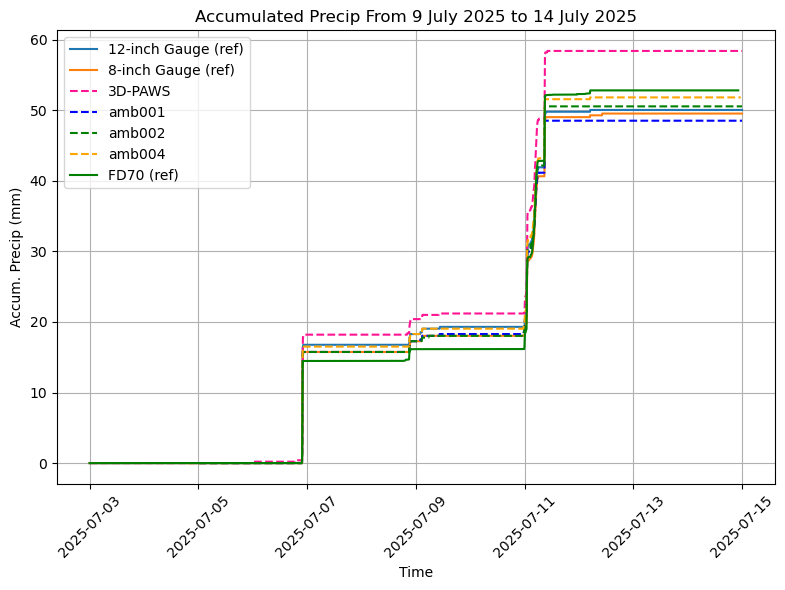

In [17]:
# Set date range
start_date = pd.Timestamp('2025-07-03')
end_date = pd.Timestamp('2025-07-15')

# --- Compute cumulative sum for TBRG gauges (already in mm) ---
accum_12in = tbrg['tb_rain_mm_12in_Tot'].cumsum()
accum_8in = tbrg['tb_rain_mm_8in_Tot'].cumsum()

# --- Slice and zero out tipping bucket gauges (12in, 8in) ---
accum_12in_slice = accum_12in.sel(time=slice(start_date, end_date))
accum_12in_zeroed = accum_12in_slice - accum_12in_slice.isel(time=0)

accum_8in_slice = accum_8in.sel(time=slice(start_date, end_date))
accum_8in_zeroed = accum_8in_slice - accum_8in_slice.isel(time=0)

# --- Slice and zero out 3D-PAWS ---
paws_precip_slice = paws_rolling_precip.loc[start_date:end_date]
paws_precip_zeroed = paws_precip_slice - paws_precip_slice.iloc[0]

# --- Slice and zero out Ambient stations ---
amb001_slice = accumPrecip001_in_mm.sel(time=slice(start_date, end_date))
amb001_zeroed = amb001_slice - amb001_slice.isel(time=0)

amb002_slice = accumPrecip002_in_mm.sel(time=slice(start_date, end_date))
amb002_zeroed = amb002_slice - amb002_slice.isel(time=0)

amb004_slice = accumPrecip004_in_mm.sel(time=slice(start_date, end_date))
amb004_zeroed = amb004_slice - amb004_slice.isel(time=0)

# --- Slice and zero out FD70 cumulative precipitation ---
fd70_slice = fd70['cum'].sel(time=slice(start_date, end_date))
fd70_zeroed = fd70_slice - fd70_slice.isel(time=0)


# --- Plot ---
plt.figure(figsize=(8, 6))
plt.plot(accum_12in_zeroed['time'], accum_12in_zeroed, label='12-inch Gauge (ref)')
plt.plot(accum_8in_zeroed['time'], accum_8in_zeroed, label='8-inch Gauge (ref)')
plt.plot(paws_precip_zeroed.index, paws_precip_zeroed.values, '--', color='deeppink', label='3D-PAWS')
plt.plot(amb001_zeroed['time'], amb001_zeroed, '--', color='blue', label='amb001')
plt.plot(amb002_zeroed['time'], amb002_zeroed, '--', color='green', label='amb002')
plt.plot(amb004_zeroed['time'], amb004_zeroed, '--', color='orange', label='amb004')
plt.plot(fd70_slice['time'], fd70_zeroed, '-', color='green', label='FD70 (ref)')

plt.xlabel('Time')
plt.ylabel('Accum. Precip (mm)')
plt.title('Accumulated Precip From 9 July 2025 to 14 July 2025')
plt.legend()
plt.grid(True)
plt.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()


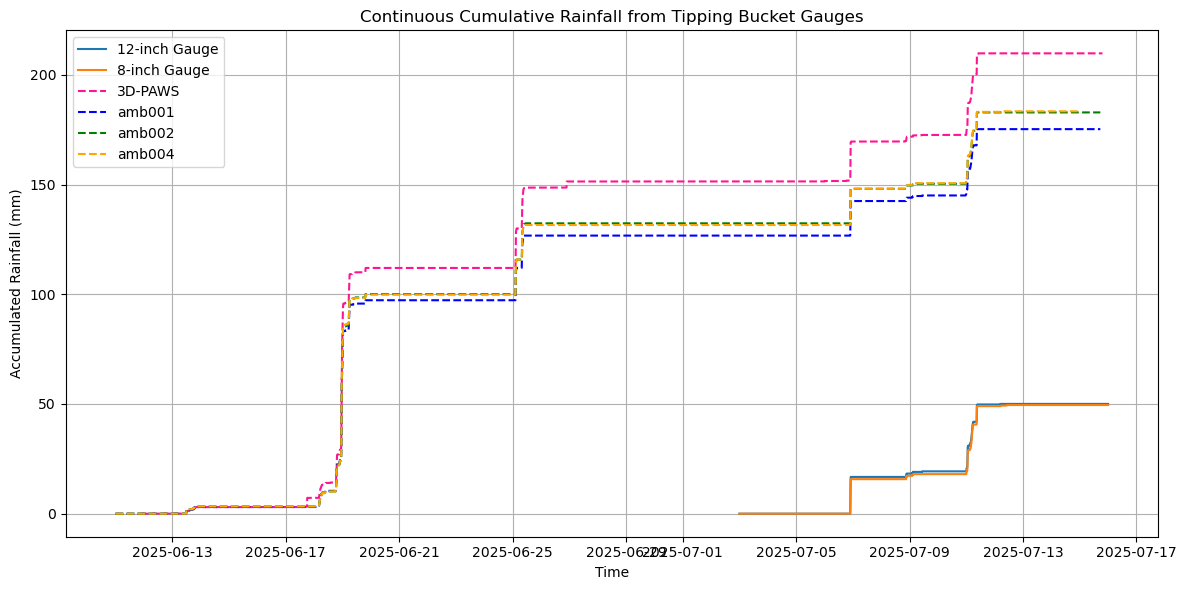

In [18]:
# Compute cumulative sum for 12-inch and 8-inch tipping bucket gauges
accum_12in = tbrg['tb_rain_mm_12in_Tot'].cumsum()
accum_8in = tbrg['tb_rain_mm_8in_Tot'].cumsum()

# Plot both
plt.figure(figsize=(12, 6))
plt.plot(accum_12in['time'], accum_12in.values, label='12-inch Gauge')
plt.plot(accum_8in['time'], accum_8in.values, label='8-inch Gauge')
plt.plot(paws_precip.index, paws_rolling_precip, '--', color='deeppink', label='3D-PAWS')
plt.plot(amb001['time'], accumPrecip001_in_mm, '--', color='blue', label='amb001')
plt.plot(amb002['time'], accumPrecip002_in_mm, '--', color='green', label='amb002')
plt.plot(amb004['time'], accumPrecip004_in_mm, '--', color='orange', label='amb004')
plt.xlabel('Time')
plt.ylabel('Accumulated Rainfall (mm)')
plt.title('Continuous Cumulative Rainfall from Tipping Bucket Gauges')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

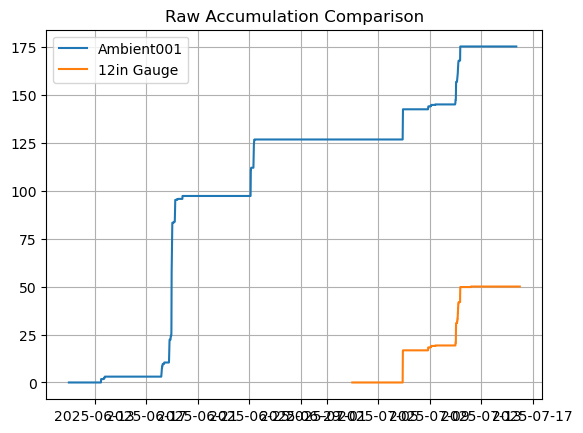

In [19]:
plt.plot(accumPrecip001_in_mm['time'], accumPrecip001_in_mm, label='Ambient001')
plt.plot(accum_12in['time'], accum_12in, label='12in Gauge')
plt.legend()
plt.title('Raw Accumulation Comparison')
plt.grid(True)
